# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [1]:
# %pip install scikit-survival
# %pip install scikitlearn
# %pip install lifelines
# %pip install tensorflow
# %pip install keras
# %pip install scikit-learn

# magic functions for Jupyter notebooks
# %matplotlib inline


In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

# Import your chosen model
import sksurv

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

from sklearn import set_config
from sklearn.preprocessing import OrdinalEncoder

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times


from sklearn.pipeline import make_pipeline





2025-06-27 10:40:52.554031: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 10:40:52.556913: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 10:40:52.567348: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 10:40:52.603391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751020852.666689   22113 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751020852.67

## Model Selection: Survival Analysis

[Discuss the type(s) of models you consider for this task, and justify the selection.]

As one of the main goals is to predict the overall survival of AML-patients, the decision of a baseline-Model fell on building a survival Analysis model.

A survival Analysis model (build with scikit-survival sksurv) is a special kind of analysis. The Cox's proportional hazards model is kind of similar to regression but takes the cumulative hazards function in the presence of addidional covariants into account.
The Survival analysis describes a time-to event regression problem which is different to a regular regression due to "censoring". 

### Censoring
Censored data can occur as right censoring (event was not observed in timeframe), left censoring (event occured before start of the timeframe of a study) or interval censoring (event occured in an roughly described time interval, but the exact time is unknown)

The dataset of Acute Myeloic Leukemia (AML) patients contains medical and biological data, as well as a status of "alive" or "dead" on the last follow-up. The dataset is affected by "right censoring", which indicates that not every patient made it to the endpoint of data collection or didn't experience the "event" while the duration of the observation- timeframe. The left censoring also affects the given dataset, as some patients probably died before or right at the start of the observation timeframe. 

(For the application of the survival analysis with the scikit-survival package, some more tailored steps of data processing are required, compared to the regular processing of most other modelling packages. This means, the categorical data has to be encoded by usage of the One hot Encoder and the data hast to be compiled to arrays then, to run the survival analysis.)




In [3]:
# load data and preview

import os

os.chdir("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics")

print(os.getcwd())

# Load the datasets

# Clinical Data

cln_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical.csv"
)  # clinical_train
cln_eval = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical_eval.csv"
)  # clinical_test

# Molecular Data
maf_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular.csv"
)  # molecular_train
maf_eval = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular_eval.csv"
)  # molecular_test

# Target Data (Outcome)
target_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_outcome.csv"
)  # target_train
target_df_test = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/ChallengeData/random_submission_FRacdcw_v9kP4pP.csv"
)  # target_test risk scores

/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics


In [4]:
# Preview the data

## Clinical

# number of rows and columns
print("Clinical Data Rows: ", cln_df.shape[0])
print("Clinical Data Columns: ", cln_df.shape[1])
print("Clinical Data Head: ", cln_df.head())

## Molecular

# number of rows and columns
print("Molecular Data Rows: ", maf_df.shape[0])
print("Molecular Data Columns: ", maf_df.shape[1])
print("Molecular Data Head: ", maf_df.head())

## Target

# number of rows and columns
print("Target Data Rows: ", target_df.shape[0])
print("Target Data Columns: ", target_df.shape[1])
print("Target Data Head: ", target_df.head())

Clinical Data Rows:  3323
Clinical Data Columns:  9
Clinical Data Head:          ID CENTER  BM_BLAST    WBC  ANC  MONOCYTES    HB    PLT  \
0  P132697    MSK      14.0    2.8  0.2        0.7   7.6  119.0   
1  P132698    MSK       1.0    7.4  2.4        0.1  11.6   42.0   
2  P116889    MSK      15.0    3.7  2.1        0.1  14.2   81.0   
3  P132699    MSK       1.0    3.9  1.9        0.1   8.9   77.0   
4  P132700    MSK       6.0  128.0  9.7        0.9  11.1  195.0   

                          CYTOGENETICS  
0      46,xy,del(20)(q12)[2]/46,xy[18]  
1                                46,xx  
2   46,xy,t(3;3)(q25;q27)[8]/46,xy[12]  
3    46,xy,del(3)(q26q27)[15]/46,xy[5]  
4  46,xx,t(3;9)(p13;q22)[10]/46,xx[10]  
Molecular Data Rows:  10935
Molecular Data Columns:  11
Molecular Data Head:          ID CHR        START          END                REF ALT    GENE  \
0  P100000  11  119149248.0  119149248.0                  G   A     CBL   
1  P100000   5  131822301.0  131822301.0          

In [5]:
# show min and max OS_YEARS of the target data
print("In target_df: ", "Min OS_YEARS:", target_df["OS_YEARS"].min())
print("In target_df: " "Max OS_YEARS:", target_df["OS_YEARS"].max())


In target_df:  Min OS_YEARS: 0.0
In target_df: Max OS_YEARS: 22.0438356164384


## Feature Engineering

[Describe any additional feature engineering you've performed beyond what was done for the baseline model.]

## Selection of Features

The overall survival prediction will be based on the generation of a risk score through the evaluation of the status (alive or dead) OS_STATUS, as event indicator and with the time measurements of survival in years OS_YEARS after last follow-up as time variable.

One of he main obstacles in working with censored data is choosing an unbiased estimator of the survival curve. There are different approaches like the Kaplan-Meyer survival probability.

Feature selection could be done randomly, or by differentiation of weighting risk-factors which would be highly desired in health-related fields.

Some main features of AML described in literature are the presence of blast cells in percentage (column 'BM_BLAST'), low concentration of Hemoglobine levels, resulting in anemia (column 'HB') as well as low levels of platelets (column 'PLT').




In [6]:
# Data preparation

# Convert 'OS_YEARS' to numeric
target_df["OS_YEARS"] = pd.to_numeric(target_df["OS_YEARS"], errors="coerce")

# Convert 'OS_STATUS' to boolean (1 for event, 0 for censored)
target_df["OS_STATUS"] = target_df["OS_STATUS"].astype(bool)
print(target_df[["OS_YEARS", "OS_STATUS"]].dtypes)


# Select features in clinical data
features = ["BM_BLAST", "HB", "PLT"]

# Select target in target data
target = ["OS_YEARS", "OS_STATUS"]



OS_YEARS     float64
OS_STATUS       bool
dtype: object


In [7]:

# Create the survival data format required for the model

X = cln_df.loc[cln_df["ID"].isin(target_df["ID"]), features]
y = Surv.from_dataframe("OS_STATUS", "OS_YEARS", target_df)

# Check shapes and types before splitting
print(y.shape, type(y))
print(len(y))

print(X.shape, type(X))
print(len(X))
print(X.dtypes)  # y has no .dtypes, its an numpy array


# Split the data into train and test sets
# usage of stratify to ensure balanced distribution of censored data in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y["OS_STATUS"], random_state=0
)

(3323,) <class 'numpy.ndarray'>
3323
(3323, 3) <class 'pandas.core.frame.DataFrame'>
3323
BM_BLAST    float64
HB          float64
PLT         float64
dtype: object


In [8]:
# create different types of data storage for differet requirements
# X_train
X_train_df = pd.DataFrame(X_train)
X_train_np = X_train.to_numpy()

# y_train
y_train_df = pd.DataFrame(y_train)
y_train_np = y_train
print(type(y_train_np))  # numpy array
# X_test
X_test_df = pd.DataFrame(X_test)
X_test_np = X_test.to_numpy()   
# y_test
y_test_df = pd.DataFrame(y_test)
y_test_np = y_test
print(type(y_test_np))  # numpy array

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
# show distribution of censored data in both train and test sets
# show number of counted patiens with event occurence in train data:
print(
    "Number of events in train data (y_train):",
    y_train["OS_STATUS"].sum(),
    ", Distribution: " ",",
    round(y_train["OS_STATUS"].sum() / len(y_train) * 100, 2),
    "%",
)
# show number of counted patiens with event occurence in test data:
print(
    "Number of events in test data (y_test):",
    y_test["OS_STATUS"].sum(),
    ", Distribution: " ",",
    round(y_test["OS_STATUS"].sum() / len(y_test) * 100, 2),
    "%",
)

Number of events in train data (y_train): 1400 , Distribution: , 52.67 %
Number of events in test data (y_test): 350 , Distribution: , 52.63 %


In [10]:
# Check the number of events in the target data

# Group by OS_STATUS and count number of events
target_df_events = target_df.groupby("OS_STATUS")["OS_STATUS"].count()

pct_target_df_events = (
    target_df.groupby("OS_STATUS")["OS_STATUS"].count() / len(target_df) * 100
).round(1)


# Print the number of events, if true print "number of deaths", if false print "number of censored"
for events, count in target_df_events.items():
    if events == True:
        print(
            "Number of deaths:",
            count,
            ",",
            pct_target_df_events[True],
            "%",
            "in target_df",
        )
    else:
        print(
            "Number of survivors:",
            count,
            ",",
            pct_target_df_events[False],
            "%",
            "in target_df",
        )

# Show the total number of samples in the target data

print("Total number of samples:", len(target_df))

Number of survivors: 1573 , 47.3 % in target_df
Number of deaths: 1750 , 52.7 % in target_df
Total number of samples: 3323


The target_df dataframe consists of a total of 3323 patients. For 1750 patients, which equals 52.7 %, the occurence of the event "death" can be observed, whereas 1573 patients, which equals 47.3 % survive at least until the endpoint of data collection.

## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]

One of the main used models for survival predictions in the medical field is the Cox's proportional hazards model.

#### Survival function: S(t) 
- probability of an individual to survive longer than an specific time t:

$$S(t)=P(T > t)$$ 


#### Hazard function
- quantification of a risk of event occurence within a short time interval, when the individual lives up to a known time  t.

#### Cumulative hazard function
- the cumulative risk of occurence of an event up to the time t. 

#### Probability density function of survival time
- the probability of individuals to survive a short time interval.

In the recent years, several Machine Learning survival algorithms have been developed to handle complex and cencored time-to-event data. One of the established algorithms is named random survival forests

In [11]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[["BM_BLAST", "HB", "PLT"]] = imputer.fit_transform(
    X_train[["BM_BLAST", "HB", "PLT"]]
)
X_test[["BM_BLAST", "HB", "PLT"]] = imputer.transform(X_test[["BM_BLAST", "HB", "PLT"]])

In [12]:
# Check the shape 
print("X_train shape:", X_train.shape, "X_train type:", type(X_train))
print("X_test shape:", X_test.shape, "X_test type:", type(X_test))
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# check if datataframe or series
print("X_train type:", type(X_train))
print("X_test type:", type(X_test))
print("y_train type:", type(y_train))
print("y_test type:", type(y_test))

X_train shape: (2658, 3) X_train type: <class 'pandas.core.frame.DataFrame'>
X_test shape: (665, 3) X_test type: <class 'pandas.core.frame.DataFrame'>
y_train shape: (2658,)
y_test shape: (665,)
X_train type: <class 'pandas.core.frame.DataFrame'>
X_test type: <class 'pandas.core.frame.DataFrame'>
y_train type: <class 'numpy.ndarray'>
y_test type: <class 'numpy.ndarray'>


## Implementation

[Implement the final model(s) you've selected based on the above steps.]




### Kaplan - Meier unconditional survival analysis
This method approaches the problem of estimatiobn of time-to-event from cecored data
The Kaplan - Meier curve shows the overall survival propability which is changing over time. At the start of the data collection it is close to one and almost all of the patients are still alive. Over time, the probability of survival decreases gradually due to the occurences of the event "death".

In [13]:
#import matplotlib.pyplot as plt

# Import the Kaplan-Meier fitter from lifelines

#from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

print(type(y_train), y_train.shape)
print(type(y_test), y_test.shape)

<class 'numpy.ndarray'> (2658,)
<class 'numpy.ndarray'> (665,)


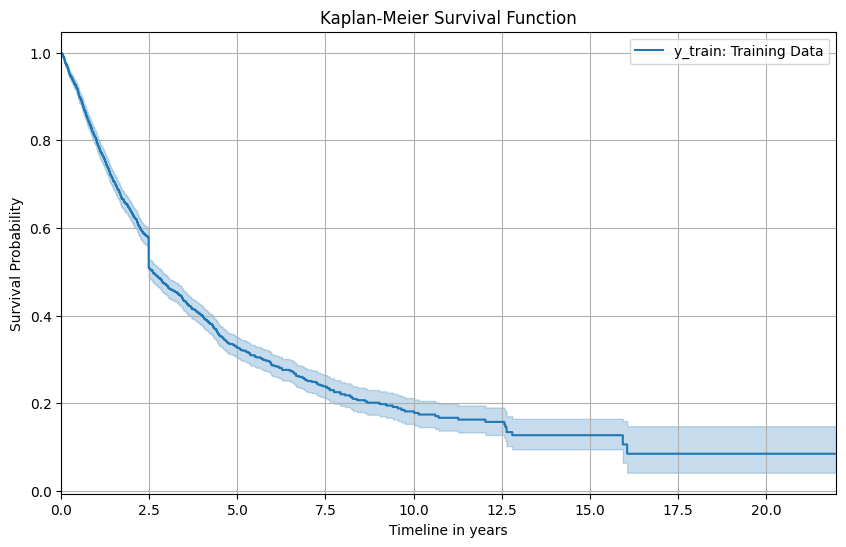

In [14]:
# Apply Kaplan-Meier survival analysis to training data

# Fit the Kaplan-Meier estimator to the training data
# y_train is a structured array with 'OS_YEARS' and 'OS_STATUS'
# 'OS_YEARS' is the time to event or censoring, 'OS_STATUS

kmf.fit(y_train["OS_YEARS"], y_train["OS_STATUS"])

# Plot the kaplan-meier survival function of training data
# set x axis max to 22 years (max survival time in the dataset)


plt.figure(figsize=(10, 6))
kmf.plot()
plt.xlim(0, 22)
plt.xlabel("Timeline in years")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Function")
plt.legend(["y_train: Training Data"])
plt.grid(True)
# plt.tight_layout()
plt.show()


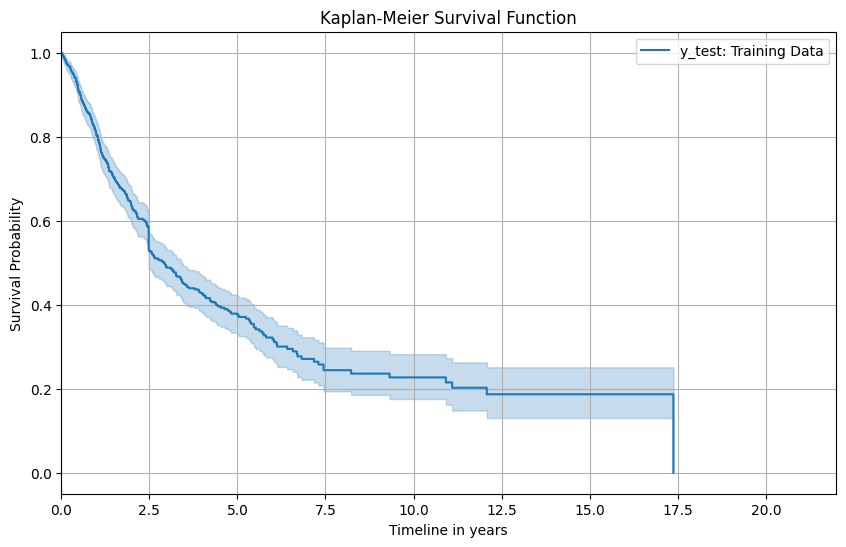

In [15]:
# Apply Kaplan-Meier survival analysis to test data

kmf.fit(y_test["OS_YEARS"], y_test["OS_STATUS"])

# Plot the kaplan-meier survival function of test data

plt.figure(figsize=(10, 6))
kmf.plot()

plt.xlim(0, 22)
plt.xlabel("Timeline in years")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Function")
plt.legend(["y_test: Training Data"])
plt.grid(True)
# plt.tight_layout()
plt.show()

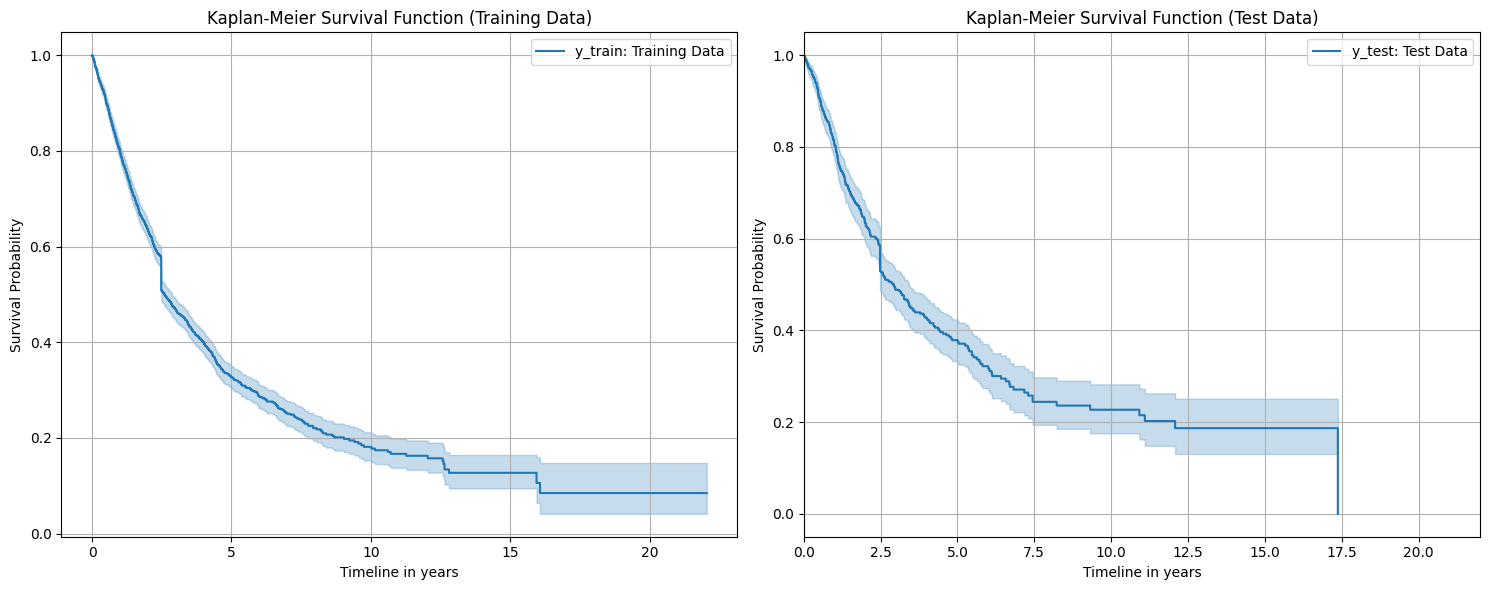

In [16]:
# plot the kaplan-meier survival function of training and test data next to each other

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

kmf.fit(y_train["OS_YEARS"], y_train["OS_STATUS"])
kmf.plot(ax=ax[0])
ax[0].set_title("Kaplan-Meier Survival Function (Training Data)")
ax[0].set_xlabel("Timeline in years")
ax[0].set_ylabel("Survival Probability")
ax[0].legend(["y_train: Training Data"])
ax[0].grid(True)

kmf.fit(y_test["OS_YEARS"], y_test["OS_STATUS"])
kmf.plot(ax=ax[1])
ax[1].set_title("Kaplan-Meier Survival Function (Test Data)")
ax[1].set_xlabel("Timeline in years")
ax[1].set_ylabel("Survival Probability")
ax[1].legend(["y_test: Test Data"])
ax[1].grid(True)

plt.xlim(0, 22)
plt.tight_layout()
plt.show()

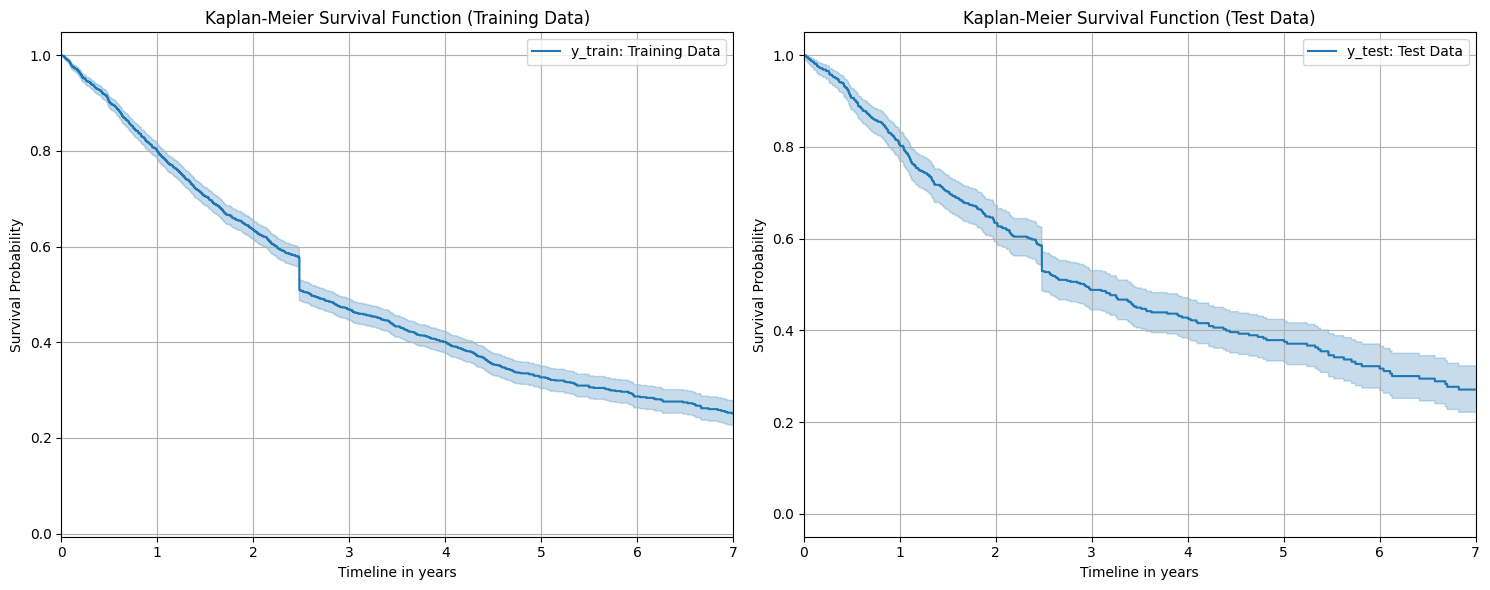

In [17]:
# Estimate the survival probability for a maximum of 7 years
max_years = 7

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

kmf.fit(y_train["OS_YEARS"], y_train["OS_STATUS"])
kmf.plot(ax=ax[0])
# make the x-axis limit 7 years
ax[0].set_xlim(0, max_years)
ax[0].set_title("Kaplan-Meier Survival Function (Training Data)")
ax[0].set_xlabel("Timeline in years")
ax[0].set_ylabel("Survival Probability")
ax[0].legend(["y_train: Training Data"])
ax[0].grid(True)

kmf.fit(y_test["OS_YEARS"], y_test["OS_STATUS"])
kmf.plot(ax=ax[1])
# make the x-axis limit 7 years
ax[1].set_xlim(0, max_years)
ax[1].set_title("Kaplan-Meier Survival Function (Test Data)")
ax[1].set_xlabel("Timeline in years")
ax[1].set_ylabel("Survival Probability")
ax[1].legend(["y_test: Test Data"])
ax[1].grid(True)


plt.tight_layout()
plt.show()

In [18]:
# print the survival probability for training data at 3 years

print("Survival probability for training data at 3 years:", round(kmf.predict(3),2))
print("Survival probability for training data at 5 years:", round(kmf.predict(5),2))
print("Survival probability for training data at 7 years:", round(kmf.predict(7),2))

Survival probability for training data at 3 years: 0.49
Survival probability for training data at 5 years: 0.38
Survival probability for training data at 7 years: 0.27


<Axes: xlabel='timeline'>

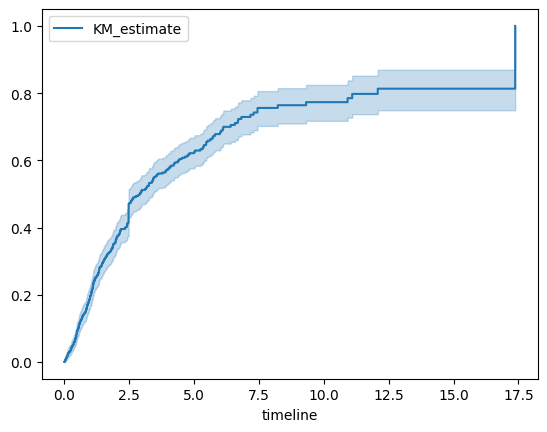

In [19]:
# Plot cumulative density (the inversed survival function) for training and test data
kmf.plot_cumulative_density()

In [20]:
# addition of median survival time
## Return the unique time point, t, such that S(t) = 0.5. This is the "half-life" of the population, 
## and a robust summary statistic for the population

median_survival_time = kmf.median_survival_time_
print("Median Survival Time kmf:", median_survival_time)

#median_survival_time_days = median_survival_times(pd.DataFrame(y_train["OS_YEARS"]))

# median survival time in years
y_test_mst_y = y_test_df["OS_YEARS"].median()
#print("y_test Median Survival Time in years:", round(y_test_mst_y, 2), "years")

#median_survival_time_days = median_survival_times((y_train_df["OS_YEARS"]))
y_test_mst_d = y_test_mst_y * 365  # Convert years to days
#print("y_test Median Survival Time in days:", round(y_test_mst_d, 2), "days")

# Median survival time in months
y_test_mst_m = y_test_mst_d / 30
#print("y_test Median Survival Time in months:", round(y_test_mst_m, 2), "months")



# median survival time in years
y_train_mst_y = y_train_df["OS_YEARS"].median()
#print("y_train Median Survival Time in years:", round(y_train_mst_y, 2), "years")

#median_survival_time_days = median_survival_times((y_train_df["OS_YEARS"]))
y_train_mst_d =  y_train_mst_y * 365  # Convert years to days
#print("y_train Median Survival Time in days:", round(y_train_mst_d, 2), "days")

# Median survival time in months
y_train_mst_m = y_train_mst_y / 30
#print("y_train Median Survival Time in months:", round(y_train_mst_m, 2), "months")


# print the median survival time in years, days and months for both training and test data
print("Median Survival Time (MST) in years:")
print("y_train:", round(y_train_mst_y, 2), "years")
print("y_test:", round(y_test_mst_y, 2), "years")

print("Median Survival Time (MST) in days:")
print("y_train:", round(y_train_mst_d, 2), "days")
print("y_test:", round(y_test_mst_d, 2), "days")

print("Median Survival Time (MST) in months:")
print("y_train:", round(y_train_mst_m, 2), "months")
print("y_test:", round(y_test_mst_m, 2), "months")





Median Survival Time kmf: 2.92054794520548
Median Survival Time (MST) in years:
y_train: 1.78 years
y_test: 1.9 years
Median Survival Time (MST) in days:
y_train: 650.0 days
y_test: 692.0 days
Median Survival Time (MST) in months:
y_train: 0.06 months
y_test: 23.07 months


In [21]:
# average survival time in years
y_train_avg_y = y_train_df["OS_YEARS"].mean()
y_test_avg_y = y_test_df["OS_YEARS"].mean()
print("Average Survival Time (AST) in years:", 
      "y_train:", round(y_train_avg_y, 2), "years",
      ", y_test:", round(y_test_avg_y, 2), "years")

Average Survival Time (AST) in years: y_train: 2.43 years , y_test: 2.68 years


In [22]:
# kmf median is giving out average survival time in years ?

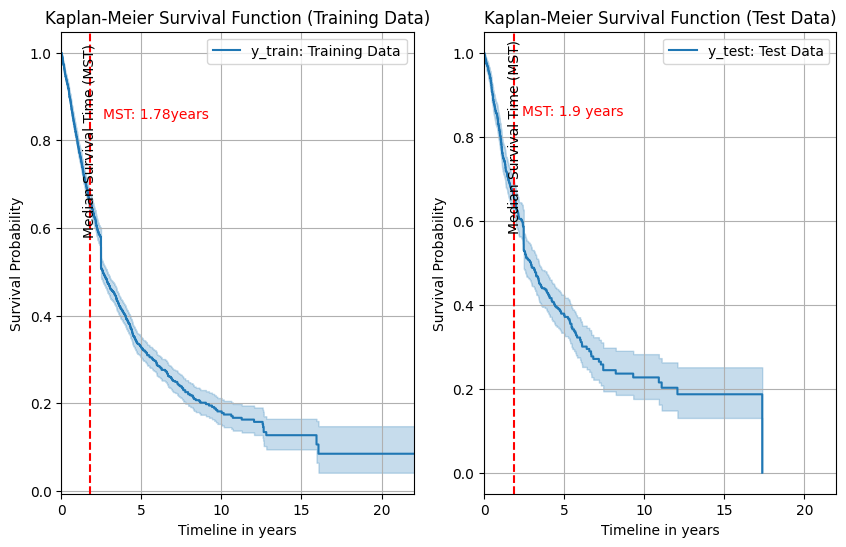

In [23]:
# plot kaplan meier survival function

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

kmf.fit(y_train["OS_YEARS"], y_train["OS_STATUS"])


kmf.plot(ax=ax[0])
# make the x-axis limit 22 years
ax[0].set_xlim(0, 22)
ax[0].set_title("Kaplan-Meier Survival Function (Training Data)")
ax[0].set_xlabel("Timeline in years")
ax[0].set_ylabel("Survival Probability")
ax[0].legend(["y_train: Training Data"])
ax[0].grid(True)
# add median survival time to the plot
ax[0].axvline(y_train_mst_y, color='red', linestyle='--')
ax[0].text(y_train_mst_y, 0.8, "Median Survival Time (MST)", rotation=90, ha="center", va="center")
# print median survival time next to the line
ax[0].text(y_train_mst_y + 0.8, 0.85, "MST: " + str(round(y_train_mst_y, 2)) + "years", color='red')

kmf.fit(y_test["OS_YEARS"], y_test["OS_STATUS"])
kmf.plot(ax=ax[1])
# make the x-axis limit 22 years
ax[1].set_xlim(0, 22)
ax[1].set_title("Kaplan-Meier Survival Function (Test Data)")
ax[1].set_xlabel("Timeline in years")
ax[1].set_ylabel("Survival Probability")
ax[1].legend(["y_test: Test Data"])
ax[1].grid(True)
# add median survival time to the plot
ax[1].axvline(y_test_mst_y, color='red', linestyle='--')
ax[1].text(y_test_mst_y, 0.8, "Median Survival Time (MST)", rotation=90, ha="center", va="center")
# print median survival time next to the line
plt.text(y_test_mst_y + 0.5, 0.85, "MST: " + str(round(y_test_mst_y, 2)) + " years", color='red')

#plt.xlim(0, 22)
#plt.tight_layout()
plt.show()

In [24]:
kmf.median_survival_time_, kmf.confidence_interval_


(np.float64(2.92054794520548),
            KM_estimate_lower_0.95  KM_estimate_upper_0.95
 0.000000                 1.000000                1.000000
 0.002740                 1.000000                1.000000
 0.005479                 1.000000                1.000000
 0.010959                 1.000000                1.000000
 0.021918                 0.987847                0.999235
 ...                           ...                     ...
 15.010959                0.130415                0.251061
 15.797260                0.130415                0.251061
 16.172603                0.130415                0.251061
 17.147945                0.130415                0.251061
 17.375342                0.000000                0.000000
 
 [550 rows x 2 columns])

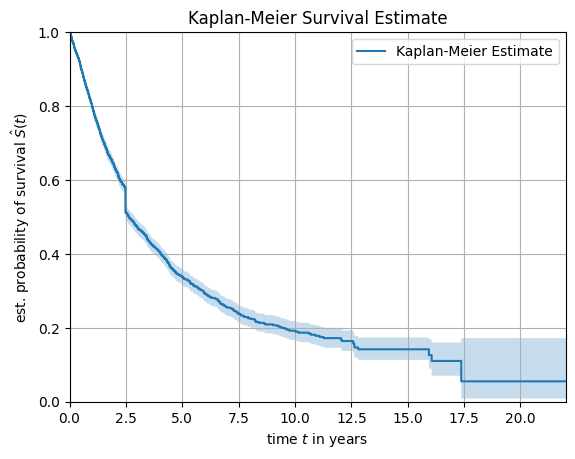

In [25]:
#time, survival_prob, conf_int = kaplan_meier_estimator(data_y[Status], data_y[days], conf_type= 'log-log')
time, survival_prob, conf_int = kaplan_meier_estimator(target_df["OS_STATUS"], target_df["OS_YEARS"], conf_type= 'log-log')
plt.step(time, survival_prob, where='post', label='Kaplan-Meier Estimate')
plt.fill_between(time, conf_int[0], conf_int[1], alpha= 0.25, step='post')
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ in years")
plt.title("Kaplan-Meier Survival Estimate")
plt.legend(loc ='best')
plt.grid(True)
plt.xlim(0, 22)
plt.show()

In [26]:
# survival functions by impact of clinical features
# categorize the clinical features

In [27]:
# create new dataframe with filtered sex?
# create a new csv file with added column for sex based on the new dataframe
# if in the column cytogenetics appears xx anywhwere, then the patient is female =1 anf if there is xy anywhere, then the patient is male = 0
# scan "Cytogenetics" column for "xx" or "xy" of cln_df 

nw_cln_df = cln_df
# add a new column for "sex" but leave it empty
nw_cln_df["Sex"] = ""


print(nw_cln_df.head())


        ID CENTER  BM_BLAST    WBC  ANC  MONOCYTES    HB    PLT  \
0  P132697    MSK      14.0    2.8  0.2        0.7   7.6  119.0   
1  P132698    MSK       1.0    7.4  2.4        0.1  11.6   42.0   
2  P116889    MSK      15.0    3.7  2.1        0.1  14.2   81.0   
3  P132699    MSK       1.0    3.9  1.9        0.1   8.9   77.0   
4  P132700    MSK       6.0  128.0  9.7        0.9  11.1  195.0   

                          CYTOGENETICS Sex  
0      46,xy,del(20)(q12)[2]/46,xy[18]      
1                                46,xx      
2   46,xy,t(3;3)(q25;q27)[8]/46,xy[12]      
3    46,xy,del(3)(q26q27)[15]/46,xy[5]      
4  46,xx,t(3;9)(p13;q22)[10]/46,xx[10]      


In [28]:
# scan CYTOGENETICS column for "xx" or "xy", ignore the rest 

# if "xx" appears anywhere in the column, then the patient is female


nw_cln_df.loc[nw_cln_df["CYTOGENETICS"].str.contains("xx", case=True), "Sex"] = "Female"

# if "xy" appears anywhere in the column, then the patient is male
nw_cln_df.loc[nw_cln_df["CYTOGENETICS"].str.contains("xy", case=True), "Sex"] = "Male"

print(nw_cln_df.head())


        ID CENTER  BM_BLAST    WBC  ANC  MONOCYTES    HB    PLT  \
0  P132697    MSK      14.0    2.8  0.2        0.7   7.6  119.0   
1  P132698    MSK       1.0    7.4  2.4        0.1  11.6   42.0   
2  P116889    MSK      15.0    3.7  2.1        0.1  14.2   81.0   
3  P132699    MSK       1.0    3.9  1.9        0.1   8.9   77.0   
4  P132700    MSK       6.0  128.0  9.7        0.9  11.1  195.0   

                          CYTOGENETICS     Sex  
0      46,xy,del(20)(q12)[2]/46,xy[18]    Male  
1                                46,xx  Female  
2   46,xy,t(3;3)(q25;q27)[8]/46,xy[12]    Male  
3    46,xy,del(3)(q26q27)[15]/46,xy[5]    Male  
4  46,xx,t(3;9)(p13;q22)[10]/46,xx[10]  Female  


In [29]:
# count the number of females = 1 and males = 0

nw_cln_df["Sex"].value_counts() 



Sex
Male      2095
Female    1130
            98
Name: count, dtype: int64

In [30]:
# survival functions for impact of sexes
# boolean female = 1, male = 0

nw_cln_df["Sex"] = nw_cln_df["Sex"].map({"Female": 1, "Male": 0})

print(nw_cln_df.head())





        ID CENTER  BM_BLAST    WBC  ANC  MONOCYTES    HB    PLT  \
0  P132697    MSK      14.0    2.8  0.2        0.7   7.6  119.0   
1  P132698    MSK       1.0    7.4  2.4        0.1  11.6   42.0   
2  P116889    MSK      15.0    3.7  2.1        0.1  14.2   81.0   
3  P132699    MSK       1.0    3.9  1.9        0.1   8.9   77.0   
4  P132700    MSK       6.0  128.0  9.7        0.9  11.1  195.0   

                          CYTOGENETICS  Sex  
0      46,xy,del(20)(q12)[2]/46,xy[18]  0.0  
1                                46,xx  1.0  
2   46,xy,t(3;3)(q25;q27)[8]/46,xy[12]  0.0  
3    46,xy,del(3)(q26q27)[15]/46,xy[5]  0.0  
4  46,xx,t(3;9)(p13;q22)[10]/46,xx[10]  1.0  


In [31]:
nw_cln_df["Sex"].value_counts()

Sex
0.0    2095
1.0    1130
Name: count, dtype: int64

## Cox Proportional Hazards

### Multivariant Survival Model


In [32]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv

from sksurv.metrics import concordance_index_ipcw


print(y_train_df)

      OS_STATUS  OS_YEARS
0         False  0.630137
1          True  0.767123
2          True  0.208219
3          True  2.480713
4          True  2.265753
...         ...       ...
2653       True  0.479452
2654       True  0.917808
2655       True  1.263014
2656      False  1.150685
2657      False  0.339726

[2658 rows x 2 columns]


In [33]:
# create cox proportional hazards model


# Training features in X_train (dataframe)
cox_X_train = X_train_df

print(cox_X_train.shape, )

# event/ time  columns in y_train (dataframe), but will be converted to structured array for survival analysis
cox_y_train = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_train_df)

print(cox_y_train.shape)

coxph = CoxPHSurvivalAnalysis()

# fit the cox proportional hazards model
coxph.fit(cox_X_train, cox_y_train)

(2658, 3)
(2658,)


CoxPHSurvivalAnalysis()

In [34]:
# cox coefficients
cox_coefficients = pd.DataFrame(coxph.coef_, index=cox_X_train.columns, columns=["coef"])
cox_coefficients["exp(coef)"] = np.exp(cox_coefficients["coef"])
cox_coefficients = cox_coefficients.sort_values("coef")
print("Cox Proportional Hazards Model Coefficients:\n", cox_coefficients, )  # get the coefficients and their standard errors

# standard error of the coefficients

Cox Proportional Hazards Model Coefficients:
               coef  exp(coef)
HB       -0.147334   0.863006
PLT      -0.001833   0.998169
BM_BLAST  0.030443   1.030911


The  cox model shows hazard ratios for every feature in relation to the other groups
coef is the estimated logarithm of the hazard ratio 
exp(coef) is the transformed log of the hazard ratio to the hazard ratio
A higher value indicates a higher risk

Therefore has the BM_BLAST value the highest impact as risk-predictor


In [35]:
# print statistics of the cox proportional hazards model
cox_summary = pd.DataFrame({
    "coef": coxph.coef_,
    "exp(coef)": np.exp(coxph.coef_),
    
    "z": coxph.z_scores_,
    "p": coxph.p_values_,
})

AttributeError: 'CoxPHSurvivalAnalysis' object has no attribute 'z_scores_'

In [ ]:
# import cox coefficients
cox_coefficients = coxph.coef_


In [ ]:
X, y = cox_X_train, cox_y_train
X = X.astype(float)
estimator = CoxPHSurvivalAnalysis().fit(X,y)

# Predict the cumulative hazard function for each sample in the training set and save it
train_chf = estimator.predict_cumulative_hazard_function(X)
print(train_chf)  # Display the first few cumulative hazard functions


[StepFunction(x=array([0.00000000e+00, 2.73972603e-03, 8.21917808e-03, ...,
        1.63890411e+01, 1.65671233e+01, 2.20438356e+01]), y=array([0.00000000e+00, 1.64094969e-03, 4.92640095e-03, ...,
        1.39737798e+01, 1.39737798e+01, 1.39737798e+01]), a=np.float64(0.27485415345437225), b=0.0)
 StepFunction(x=array([0.00000000e+00, 2.73972603e-03, 8.21917808e-03, ...,
        1.63890411e+01, 1.65671233e+01, 2.20438356e+01]), y=array([0.00000000e+00, 1.64094969e-03, 4.92640095e-03, ...,
        1.39737798e+01, 1.39737798e+01, 1.39737798e+01]), a=np.float64(0.1543625613827085), b=0.0)
 StepFunction(x=array([0.00000000e+00, 2.73972603e-03, 8.21917808e-03, ...,
        1.63890411e+01, 1.65671233e+01, 2.20438356e+01]), y=array([0.00000000e+00, 1.64094969e-03, 4.92640095e-03, ...,
        1.39737798e+01, 1.39737798e+01, 1.39737798e+01]), a=np.float64(0.18877424617972616), b=0.0)
 ...
 StepFunction(x=array([0.00000000e+00, 2.73972603e-03, 8.21917808e-03, ...,
        1.63890411e+01, 1.656712

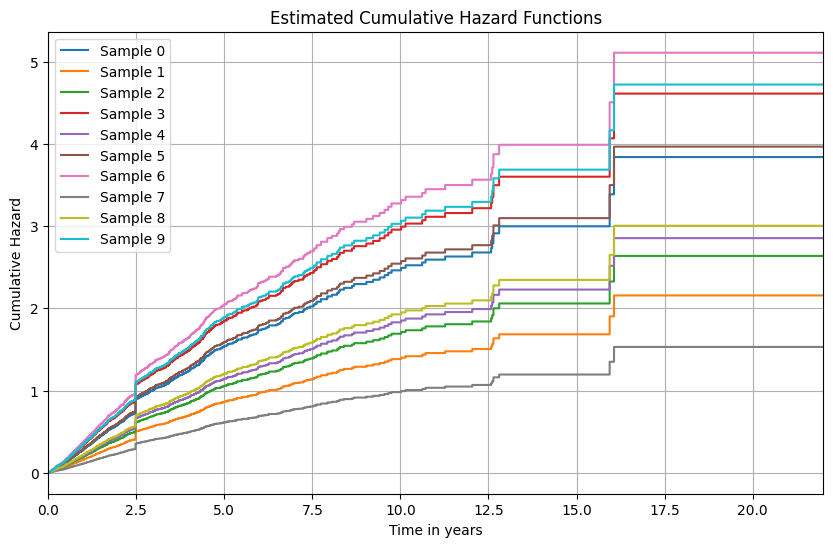

In [ ]:
# plot the estimated cumulative hazard functions
plt.figure(figsize=(10, 6))
plt.title("Estimated Cumulative Hazard Functions")
plt.xlabel("Time in years")
plt.ylabel("Cumulative Hazard")
plt.grid(True)  
plt.xlim(0, 22)  # Set x-axis limit to 22 years

for fn in chf_funcs:
    plt.step(fn.x, fn(fn.x), where = 'post')
plt.legend(["Sample {}".format(i) for i in range(random)])
plt.show()

In [ ]:
# cox coefficients with complete clinical data
cox_coefficients = pd.DataFrame(coxph.coef_, index=cox_X_train.columns, columns=["coef"])
#cox_coefficients = pd.DataFrame(coxph.coef_, index=cln_df.columns, columns=["coef"])
cox_coefficients["exp(coef)"] = np.exp(cox_coefficients["coef"])
cox_coefficients = cox_coefficients.sort_values("coef")
print("Cox Proportional Hazards Model Coefficients:\n", cox_coefficients, )  # get the coefficients and their standard errors

# standard error of the coefficients
cox_summary = pd.DataFrame({
    "coef": coxph.coef_,
    "exp(coef)": np.exp(coxph.coef_),
    "std err": coxph.standard_errors_,
}, index=cox_X_train.columns)
cox_summary = cox_summary.sort_values("coef")
print("Cox Proportional Hazards Model Summary:\n", cox_summary)


Cox Proportional Hazards Model Coefficients:
               coef  exp(coef)
HB       -0.147334   0.863006
PLT      -0.001833   0.998169
BM_BLAST  0.030443   1.030911


AttributeError: 'CoxPHSurvivalAnalysis' object has no attribute 'standard_errors_'

In [ ]:

# Predict the risk scores for the test set
cox_X_test = X_test_df
cox_y_test = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_test_df)

risk_scores = coxph.predict(cox_X_test)  # Predict the risk scores for the test set

# print the risk scores for the first 5 samples
print("Risk scores for the first 5 samples:", risk_scores[:5])
# save risk scores with mathching sample IDs
risk_scores_df = pd.DataFrame({"sample_ID": y_test_df[], "Risk Score": risk_scores})

print(risk_scores_df.head())


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3951364336.py, line 10)

In [ ]:
# show cox proportional hazards model coefficients

# set coefficients for the cox proportional hazards model


In [ ]:
# prepare data for IPCW evaluation
print(type(y_test))
cox_y_test = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_test)

cox_X_test = X_test

<class 'numpy.ndarray'>


TypeError: expected pandas.DataFrame, but got <class 'numpy.ndarray'>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

set_config(display="text")  # displays text representation of estimators

In [ ]:
# load data from dataset
X = nw_cln_df[["ID", "BM_BLAST"]]

y = Surv.from_dataframe("OS_STATUS", "OS_YEARS", target_df)

# for one-hot encoding
X = X.astype(str)

# set category type for one-hot encoding
X = X.astype("category")

# drop ID column
X = X.drop("ID", axis=1)




# perform one-hot encoding of target_df


Xt = OneHotEncoder().fit_transform(X)
Xt.round(2).head()



In [ ]:
alphas = 10.0 ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(Xt.columns)

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

In [ ]:
# 

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import pandas as pd
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sksurv.datasets import load_flchain, load_gbsg2
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv

set_config(display="text")  # displays text representation of estimators
plt.rcParams["figure.figsize"] = [7.2, 4.8]



In [ ]:
from sksurv.ensemble import RandomSurvivalForest

rsf = make_pipeline(OneHotEncoder(), RandomSurvivalForest(n_estimators=100, min_samples_leaf=7, random_state=0))
rsf.fit(va_x_train, va_y_train)

In [ ]:
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(va_x_test, return_array=False)
rsf_risk_scores = np.vstack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(va_y_train, va_y_test, rsf_risk_scores, va_times)

## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]



## Concordance index (C-index)

The metric of the C-index evaluates a model by comparing pairs of individuals with the occurence of the event "death" and ranks them accordingly to their predicted risk scores. Correctly ordered pairs are called "concordant".
In the context of right-censored data, the C-index measures the probability of a correctly assigned classifier to a random pair of patients with different probability of event occurence in each individual. 

It is also known as the Harrell's concordance index, and will return values which are biased upwards if there is a high number of censoring in the test data. Therefore the Inversed Probability Censoring Index IPCW is proposed to be the alternative, as it behaves better for highly censored data.

The C-index returns values between 0 and 1, where 0.5 corresponds to a pair with identical predicted risks and is compareable to Area Under Curve (AUC) when the data is complete (not censored)

In [ ]:
# Evaluate the model using Concordance index C-index for censored data
import numpy as np
from sksurv.metrics import concordance_index_censored

# Convert datatypes to numpy arrays

cox_y_train = cox_y_train.to_numpy()
cox_y_test = cox_y_test.to_numpy()
cox_X_train = cox_X_train.to_numpy()
cox_X_test = cox_X_test.to_numpy()


cox_cindex_train = concordance_index_censored(
    cox_y_train, cox_y_train, coxph.predict(cox_X_train)
)
cox_cindex_test = concordance_index_censored(
    cox_y_train, cox_y_test, coxph.predict(cox_X_test)
)

print(
    "Cox Proportional Hazard Model Concordance Index C-index on train: {:.2f}".format(
        cox_cindex_train
    )
)
print(
    "Cox Proportional Hazard Model Concordance Index C-index on test: {:.2f}".format(
        cox_cindex_test
    )
)

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

## Inversed Probability Censoring Weighting (IPCW)

The IPCW is an alternative estimator to the concordance index and does not depend on the distribution of censoring times in the test data. This leads to an unbiased and consistent concordance measure for a population without censoring.

The IPCW represents the inversed probability of censoring weights, while estimating the censoring distribution based on the survival times of the training data.



In [ ]:
# Evaluate the model using Concordance Index IPCW
from sksurv.metrics import concordance_index_ipcw


# Initialize and train the Cox Proportional Hazards model
coxph = CoxPHSurvivalAnalysis()
coxph.fit(cox_X_train, cox_y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(
    cox_y_train, cox_y_train, coxph.predict(cox_X_train), tau=7
)[0]
cox_cindex_test = concordance_index_ipcw(
    cox_y_train, cox_y_test, coxph.predict(cox_X_test), tau=7
)[0]

print(
    "Cox Proportional Hazard Model Concordance Index IPCW on train: {:.2f}".format(
        cox_cindex_train
    )
)
print(
    "Cox Proportional Hazard Model Concordance Index IPCW on test: {:.2f}".format(
        cox_cindex_test
    )
)

NameError: name 'cox_y_test' is not defined

In [ ]:
# Evaluate the  model
# Example for a classification problem
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# For a regression problem, you might use:
# mse = mean_squared_error(y_test, y_pred)

In [ ]:
# Neural Network approach

# Define the model architecture
input_shape = X_train.shape[1:]


# Create the model

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="relu", input_shape=input_shape),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


# Train the model
model.fit(X_train, y_train["OS_STATUS"], epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-25 14:33:43.907582: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5520 - loss: 1.3287 - val_accuracy: 0.4962 - val_loss: 0.7121
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5787 - loss: 0.6861 - val_accuracy: 0.5169 - val_loss: 0.7844
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5710 - loss: 0.7868 - val_accuracy: 0.6259 - val_loss: 0.6764
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5564 - loss: 0.7087 - val_accuracy: 0.5658 - val_loss: 0.6837
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5923 - loss: 0.6792 - val_accuracy: 0.6109 - val_loss: 0.6751
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5705 - loss: 0.6929 - val_accuracy: 0.6128 - val_loss: 0.6750
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5745 - loss: 0.6916 - val_accuracy: 0.5846 - val_loss: 0.7881
Epoch 8/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5829 - loss: 0.7042 - val_accuracy: 0.5113 - val_loss: 0.7850
Epo

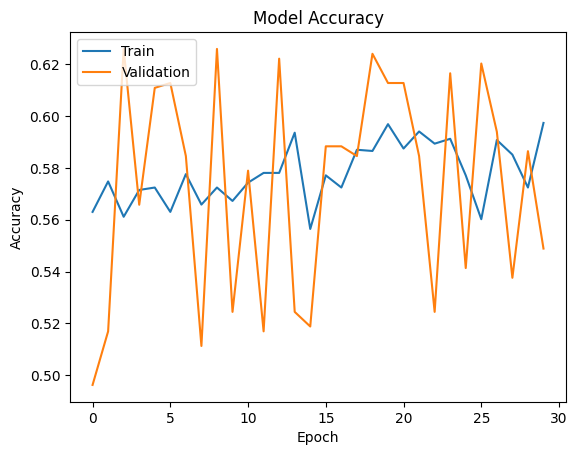

In [ ]:
# plot accuracy of the model

# plot the accuracy of the model
plt.plot(model.history.history["accuracy"])
plt.plot(model.history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [ ]:
# test the model
y_pred = model.predict(X_test)


# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test["OS_STATUS"])
mse = mean_squared_error(y_test["OS_STATUS"], y_pred)
mae = mean_absolute_error(y_test["OS_STATUS"], y_pred)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5806 - loss: 0.6761 


In [ ]:
# summarize the model
model.summary()
# Evaluate the model
from sklearn.metrics import accuracy_score, mean_squared_error

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Test mean squared error:", mse)
print("Test mean absolute error:", mae)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,109 (27.77 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,740 (18.52 KB)

Test loss: 0.6882949471473694
Test accuracy: 0.5593984723091125
Test mean squared error: 0.24607130885124207
Test mean absolute error: 0.47106629610061646


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# calculate mean absolute error mae
mae = mean_absolute_error(y_test["OS_YEARS"], y_pred)

print("Mean Absolute Error mae:", mae)


# calculate root mean squared error rmse
rmse = np.sqrt(mean_squared_error(y_test["OS_YEARS"], y_pred))

print("Root Mean Squared Error rmse:", rmse)

Mean Absolute Error mae: 2.219208120991753
Root Mean Squared Error rmse: 3.4831859942482595


In [ ]:
import keras
import matplotlib.pyplot as plt
import seaborn as sns


# Plot the accuracy of the model
plt.figure(figsize=(10, 6))
sns.lineplot(x=history.history["accuracy"], label="Train")
sns.lineplot(x=history.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy of the Model")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'history' is not defined

<Figure size 1000x600 with 0 Axes>

## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [ ]:
# evaluation of different models
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")
